[Training](#Training)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, RocCurveDisplay, roc_auc_score, roc_curve, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
import os
from xgboost import XGBClassifier

In [ ]:
path = '../Data/df_clean_null.pkl'
df = pd.read_pickle(path)

In [ ]:
feature_names = ['_RFHLTH', '_HCVU651', '_RFHYPE5', '_RFCHOL', '_ASTHMS1', '_DRDXAR1', '_RACEGR3', '_AGE_G', '_BMI5CAT', '_EDUCAG', '_INCOMG', '_SMOKER3',\
    '_RFDRHV5', '_PACAT1', '_RFSEAT2', '_FLSHOT6', '_PNEUMO2', '_AIDTST3', 'CHCCOPD1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'DRADVISE']
target_name = ['_MICHD']
weights_name = ['_LLCPWT'] 

In [ ]:
df = df[feature_names + target_name + weights_name]
df

In [ ]:
for column in ['_RFHYPE5', '_RFCHOL', '_RFDRHV5']:
    df[column] = df[column].apply(lambda x: 1.0 if x == 2.0 else 2.0 if x == 1.0 else x)

In [ ]:
for column in ['_FLSHOT6', '_PNEUMO2']:
    df[column] = df[column].cat.add_categories([65.0])
    df[column] = df[column].fillna(65.0)

In [ ]:
df['DIABETE3'] = df['DIABETE3'].map({1.0:1.0, 2.0:1.0, 3.0:2.0, 4.0:2.0, 7.0:7.0, 9.0:9.0}).astype('category')

In [ ]:
df['_MICHD'] = df['_MICHD'].apply(lambda x: 0.0 if x == 2 else x)

In [ ]:
def imputer(dataframe, category_value_tofill=None, columns_drop=None, columns_mode=None, columns_median=None):
    '''Imputes missing values to the input dataframe.
    
       Parameters
       ----------
       dataframe: Pandas dataframe
           dataframe with which to impute missing values.
       
       category_value_tofill: int, float, or string
           Value to used to fill missing values in categorical features.
       
       columns_drop: list-like
           List of columns to drop.
       
       columns_mode: list-like
           List of numeric columns to impute with the mode.
           
       columns_median: list-like
           List of numeric columns to impute with the mean.
    '''
    #Fill null values in categorical features with value_null
    if category_value_tofill != None:
        for column in dataframe.select_dtypes(include='category').columns:
            if any(dataframe[column].isnull()):
                dataframe[column] = dataframe[column].cat.add_categories([category_value_tofill])
                dataframe[column] = dataframe[column].fillna(value=category_value_tofill)
            
    #Droping columns, imputing with mode, and imputing with median.
    if columns_drop != None:
        dataframe = dataframe.drop(columns=columns_drop)
    if columns_mode != None:
        dataframe = dataframe.fillna(dataframe[columns_mode].mode().iloc[0, :])
    if columns_median != None:
        dataframe = dataframe.fillna(dataframe[columns_median].median())
    
    return dataframe

In [ ]:
df = imputer(df, 999.0)

In [ ]:
trans_list = ['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol', 'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat', 'Education_Level', 'Income_Level', \
    'Smoker_Status', 'Heavy_Drinker', 'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV', 'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX', \
        'Marital Status', 'Sodium', 'Heart_Disease', 'Sample_Weights']

In [ ]:
trans_dict = dict(zip(feature_names + target_name + weights_name, trans_list))
trans_dict

In [ ]:
df = df.rename(columns=trans_dict)
df

In [ ]:
df = df.drop(df[df[trans_dict[target_name[0]]] == 999.0].index)

In [ ]:
cols_to_one_hot = [column for column in df.select_dtypes(include='category').columns if column not in ['Heart_Disease']]

column_trans = ColumnTransformer([('categorical', OneHotEncoder(sparse=False), cols_to_one_hot)], remainder='passthrough')
column_trans.fit(df)
column_names_trans = np.concatenate([column_trans.named_transformers_['categorical'].get_feature_names_out(), np.array([trans_dict[target_name[0]], trans_dict[weights_name[0]]])])

In [ ]:
df = pd.DataFrame(column_trans.transform(df), columns=column_names_trans)
df

In [ ]:
with open('../Data/modeling_df.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(trans_dict, f)

## Training

In [17]:
with open('../Data/modeling_df.pkl', 'rb') as f:
    df = pickle.load(f)
    
y = df['Heart_Disease']
w = df['Sample_Weights']
X = df.drop(columns=[y.name, w.name])

In [18]:
class LogisticRegressionCustom(LogisticRegression):
    def __init__(self, max_iter=100, class_weight=None, threshold=None):
        super().__init__(max_iter=max_iter, class_weight=class_weight)
        self.threshold = threshold
    
    def predict(self, X):
        if self.threshold != None:
            return (super().predict_proba(X)[:, 1] >= self.threshold).astype(int)
        else:
            return super().predict(X)

In [19]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

In [20]:
def find_threshold(y_true, y_proba, set_tpr, sample_weight=None):
    _, tpr_list, threshold_list = roc_curve(y_true, y_proba, sample_weight=sample_weight)
    for tpr, threshold in zip(tpr_list, threshold_list):
        if (tpr >= set_tpr):
            return tpr, threshold

In [21]:
def my_scorer(y_test, y_pred, y_pred_proba=None, sample_weight=None, model_name=None, output=True):
    prfs_scores = precision_recall_fscore_support(y_test, y_pred, sample_weight=sample_weight)
    roc_auc_score_ = roc_auc_score(y_test, y_pred, sample_weight=sample_weight)
    scores = *prfs_scores, roc_auc_score_
    
    cf_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize = 'true')
    if output == True:
        if type(model_name) != type(None):
            plt.title(model_name)
        plt.show()
        print()
        
    if output == True:
        print(f'Classification Report: {model_name if type(model_name) != type(None) else ""}')
    class_report = classification_report(y_test, y_pred, sample_weight=sample_weight)
    if output == True:
        print(class_report)
        print()
    
    if type(y_pred_proba) != type(None):
        roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba, sample_weight=sample_weight)
        if output == True:
            if model_name != None:
                plt.title(model_name)
            plt.show()
    else:
        roc_display = None
        
    return scores, (cf_display, class_report, roc_display)

In [22]:
def my_pipeline(ml_algo, *data, model_name=None, algo_params={}, resampler=None, split_params={}, output=True):
    if len(data) not in [2, 3]:
        print(f'Invalid length for "data": {len(data)}.')
        return
    
    results = {}
    
    split_result = train_test_split(*data, **split_params)
    if len(split_result) == 4:
        X_train, X_test, y_train, y_test = split_result
        w_train = None
        w_test = None
    elif len(split_result) == 6:
        X_train, X_test, y_train, y_test, w_train, w_test = split_result
    else:
        print('Invalid length for "split_result".')
        return
        
    if type(resampler) != type(None):
        X_train, y_train = resampler().fit_resample(X_train, y_train)
    
    model = ml_algo(**algo_params)
    model.fit(X_train, y_train, sample_weight=w_train)
    results['model_info'] = model_name, model
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba = None
        
    results['predictions_train'] = y_pred_train, y_pred_proba_train
    results['predictions'] =y_pred, y_pred_proba
    
    results['scores_train'], results['displays_train'] = my_scorer(y_train, y_pred_train, y_pred_proba_train, sample_weight=w_train, model_name=model_name + ' (train)', output=output)
    results['scores'], results['displays'] = my_scorer(y_test, y_pred, y_pred_proba, sample_weight=w_test, model_name=model_name, output=output)
    
    return results


In [23]:
def grid_cv_scorer(ml_algo, scoring, *data, model_name=None, param_grid={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo())])
    else:
        model = Pipeline([(model_name, ml_algo())])
        
    keys = [k for k in param_grid.keys()]
    for key in keys:
        param_grid[model_name + '__' + key] = param_grid.pop(key)
    
    clf = GridSearchCV(model, param_grid=param_grid, scoring=scoring, refit=False)
    clf.fit(X, y, CVSearch_Test__sample_weight=w)
    cv_scores = clf.cv_results_
    print('Printing cv_scores keys:')
    print(cv_scores.keys())
    print('Printing cv_scores:')
    print(cv_scores)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    dict_scores = {}
    #dict_scores['estimator'] = cv_scores['estimator']
    for score in scoring:
        #scores_ = cv_scores['test_' + score]
        mean_array = cv_scores['mean_test_' + score]
        std_array = cv_scores['std_test_' + score]
        
        dict_scores[score]= dict(zip(['mean', 'std'], [mean_array, std_array]))
        
        if output == True:
            print(score + ' mean: ', mean_array)
            print(score + ' std: ', std_array)
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:dict_scores}
    else:
        return dict_scores

In [24]:
def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={model_name + '__sample_weight':w}, return_estimator=True)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    dict_scores = {}
    dict_scores['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        dict_scores[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:dict_scores}
    else:
        return dict_scores

In [25]:
def plot_feature_importance(importances, labels, title=None, num=20):
    num = num * (-1) - 1
    indices = importances.argsort()[:num:-1]
    plt.bar(x=labels[indices], height=importances[indices])
    plt.xticks(rotation=90)
    if type(title) != type(None):
        plt.title(title)
    plt.show()

In [26]:
precision_score_pos = make_scorer(precision_score, pos_label=1)
precision_score_neg = make_scorer(precision_score, pos_label=0)

recall_score_pos = make_scorer(recall_score, pos_label=1)
recall_score_neg = make_scorer(recall_score, pos_label=0)

f1_score_pos = make_scorer(f1_score, pos_label=1)
f1_score_neg = make_scorer(f1_score, pos_label=0)

roc_auc_scorer = make_scorer(roc_auc_score)

In [ ]:
grid_cv_results = grid_cv_scorer(LogisticRegressionCustom, {'precision':precision_score_pos, 'recall':recall_score_pos}, X, y, model_name='CVSearch_Test', param_grid={'max_iter':[500, 600]}, \
    resampler=RandomOverSampler)

In [ ]:
grid_cv_results

In [ ]:
algo_list = {'Logistic Regression':LogisticRegressionCustom, 'Random Forest':RandomForestClassifier, 'XGBoost':XGBClassifier}
algo_params_list = [dict(max_iter=500), dict(n_estimators=100), {}]
imbalance_strategy_list = {'Basic':None, 'Class Weight':None, 'Random Oversmpling':RandomOverSampler, 'Smote':SMOTE, 'Random Undersampler':RandomUnderSampler}
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}

cv_results = {}

for algo_name, algo_params in zip(algo_list, algo_params_list):
    for resampler_name, resampler in imbalance_strategy_list.items():
        if resampler_name == 'Basic':
            data = X, y, w
        else:
            data = X, y
        if resampler_name == "Class Weight":
            algo_params['class_weight'] = 'balanced'
            
        cv_results.update(cv_scorer(algo_list[algo_name], scores, *data, model_name=algo_name+', '+resampler_name, algo_params=algo_params, resampler=resampler))
        
        with open('../Data/modeling_results.pkl', 'wb') as f:
            pickle.dump(cv_results, f)


In [ ]:
algo_list = {'XGBoost':XGBClassifier}
algo_params_list = [{}]
imbalance_strategy_list = {'Basic':None, 'Random Oversmpling':RandomOverSampler, 'Smote':SMOTE, 'Random Undersampler':RandomUnderSampler}
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}

for algo_name, algo_params in zip(algo_list, algo_params_list):
    for resampler_name, resampler in imbalance_strategy_list.items():
        if resampler_name == 'Basic':
            data = X, y, w
        else:
            data = X, y
        if resampler_name == "Class Weight":
            algo_params['class_weight'] = 'balanced'
            
        cv_results.update(cv_scorer(algo_list[algo_name], scores, *data, model_name=algo_name+', '+resampler_name, algo_params=algo_params, resampler=resampler))
        
        with open('../Data/modeling_results.pkl', 'wb') as f:
            pickle.dump(cv_results, f)

In [13]:
def results_to_df(cv_results):
    columns = []
    for score in cv_results[list(cv_results.keys())[0]].keys():
        columns.append(score + '_mean')
        columns.append(score + '_std')
    
    data = []
    index = []
    for model_name in cv_results:
        index.append(model_name)
        row = []
        for score in cv_results[model_name]:
            row.append(cv_results[model_name][score]['mean'])
            row.append(cv_results[model_name][score]['std'])
        data.append(row)
        
    return pd.DataFrame(data, index=index, columns=columns)

In [6]:
results_df = results_to_df(cv_results)
results_df

,precision_pos_mean,precision_pos_std,precision_neg_mean,precision_neg_std,recall_pos_mean,recall_pos_std,recall_neg_mean,recall_neg_std,f1_pos_mean,f1_pos_std,f1_neg_mean,f1_neg_std,roc_auc_mean,roc_auc_std
"Logistic Regression, Basic",0.527923,0.008592,0.920150,0.000730,0.112753,0.009544,0.990230,0.000873,0.185621,0.013114,0.953904,0.000173,0.551492,0.004374
"Logistic Regression, Class Weight",0.230812,0.004329,0.973399,0.001171,0.789687,0.012040,0.744919,0.009696,0.357149,0.004133,0.843927,0.005812,0.767303,0.002059
"Logistic Regression, Random Oversmpling",0.230803,0.004462,0.973397,0.001256,0.789661,0.012845,0.744899,0.010114,0.357129,0.004219,0.843910,0.006047,0.767280,0.002215
"Logistic Regression, Smote",0.229910,0.002401,0.972232,0.001360,0.779592,0.013210,0.747002,0.007520,0.355054,0.001844,0.844837,0.004334,0.763297,0.003082
"Logistic Regression, Random Undersampler",0.230504,0.003929,0.973449,0.001094,0.790283,0.011201,0.744315,0.008913,0.356851,0.003744,0.843565,0.005342,0.767299,0.001938
"Random Forest, Basic",0.374947,0.013280,0.917658,0.000378,0.086480,0.004861,0.986033,0.000758,0.140497,0.006972,0.950618,0.000344,0.536257,0.002280
"Random Forest, Class Weight",0.300763,0.008545,0.918593,0.000360,0.107059,0.004754,0.975888,0.001014,0.157864,0.005834,0.946374,0.000440,0.541473,0.002139
"Random Forest, Random Oversmpling",0.305289,0.002620,0.926621,0.000471,0.222452,0.006702,0.950963,0.001719,0.257302,0.004307,0.938633,0.000628,0.586707,0.002558
"Random Forest, Smote",0.367089,0.002649,0.921804,0.000318,0.145419,0.004700,0.975707,0.001034,0.208253,0.004435,0.947989,0.000325,0.560563,0.001840
"Random Forest, Random Undersampler",0.213221,0.003118,0.972713,0.001153,0.792302,0.011405,0.716702,0.008975,0.335972,0.003069,0.825273,0.005580,0.754502,0.002036


In [47]:
with open('../Data/modeling_results.pkl', 'rb') as f:
    cv_results = pickle.load(f)

In [27]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, train_size=0.2)
bst = XGBClassifier()
bst.fit(X_train, y_train, sample_weight=w_train)

/home/hiram/Springboard/.conda/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hiram/Springboard/.conda/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:40:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred_train = bst.predict(X_train)
y_proba_train = bst.predict_proba(X_train)[:, 1]
y_pred = bst.predict(X_test)
y_proba = bst.predict_proba(X_test)[:, 1]

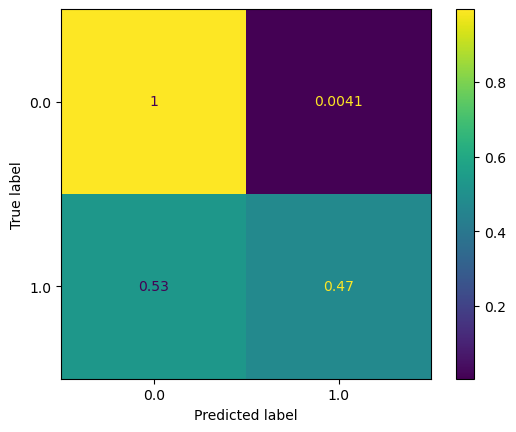


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98 46675560.563483
         1.0       0.89      0.47      0.61 3218879.165964264

    accuracy                           0.96 49894439.72944726
   macro avg       0.93      0.73      0.80 49894439.72944726
weighted avg       0.96      0.96      0.96 49894439.72944726




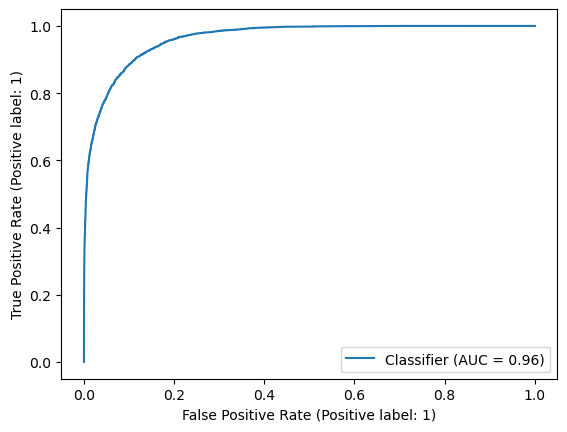

((array([0.96461488, 0.88721571]),
  array([0.99587733, 0.47026647]),
  array([0.97999684, 0.61470832]),
  array([46675560.563483  ,  3218879.16596426]),
  0.7330718984869381),
 (<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fbc5a0c4250>,
  '              precision    recall  f1-score   support\n\n         0.0       0.96      1.00      0.98 46675560.563483\n         1.0       0.89      0.47      0.61 3218879.165964264\n\n    accuracy                           0.96 49894439.72944726\n   macro avg       0.93      0.73      0.80 49894439.72944726\nweighted avg       0.96      0.96      0.96 49894439.72944726\n',
  <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fbc8ba7a0e0>))

In [43]:
my_scorer(y_train, y_pred_train, y_proba_train, sample_weight=w_train)

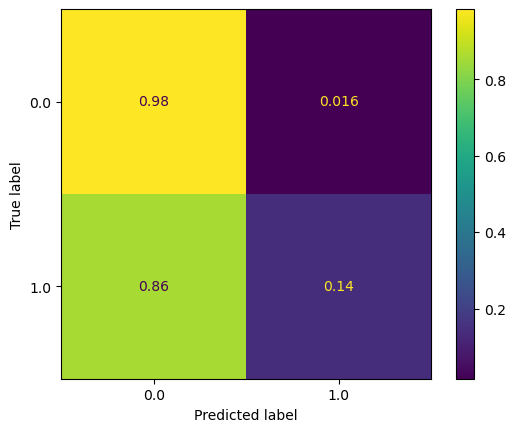


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96 186704338.92073634
         1.0       0.38      0.14      0.21 12790022.220305989

    accuracy                           0.93 199494361.14104232
   macro avg       0.66      0.56      0.59 199494361.14104232
weighted avg       0.91      0.93      0.91 199494361.14104232




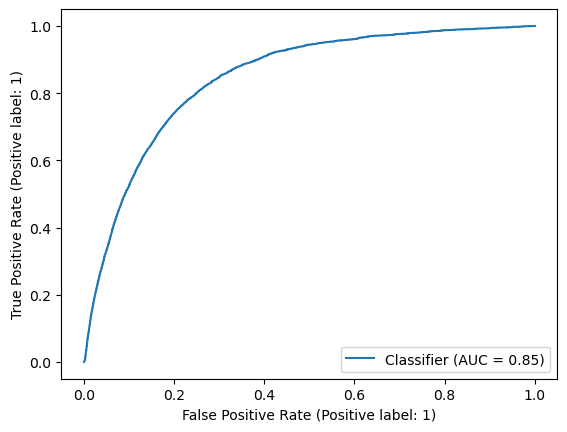

((array([0.94365861, 0.37604756]),
  array([0.98379522, 0.14256649]),
  array([0.96330902, 0.2067502 ]),
  array([1.86704339e+08, 1.27900222e+07]),
  0.5631808553447942),
 (<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fbca4c15f00>,
  '              precision    recall  f1-score   support\n\n         0.0       0.94      0.98      0.96 186704338.92073634\n         1.0       0.38      0.14      0.21 12790022.220305989\n\n    accuracy                           0.93 199494361.14104232\n   macro avg       0.66      0.56      0.59 199494361.14104232\nweighted avg       0.91      0.93      0.91 199494361.14104232\n',
  <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fbca4be55a0>))

In [45]:
my_scorer(y_test, y_pred, y_proba, sample_weight=w_test)

In [30]:
help(bst)

Help on XGBClassifier in module xgboost.sklearn object:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', use_label_encoder: bool = True, **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |      use_label_encoder : bool
 |          (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
 |          code, we recommend that you set this parameter to False.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      learning_rate : Optional[float]
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : Optional[int]
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
